In [7]:
import numpy as np  
from skimage.feature import corner_harris, corner_peaks  , corner_subpix
from skimage.color import rgb2gray  
import matplotlib.pyplot as plt  
import skimage.io as io  
import cv2
from itertools import zip_longest
# np.set_printoptions(threshold=np.nan)
import sklearn.preprocessing

In [2]:
import os
os.getcwd()


'/Users/Levis/Developer/Workspaces/KU_CV/Assignment3'

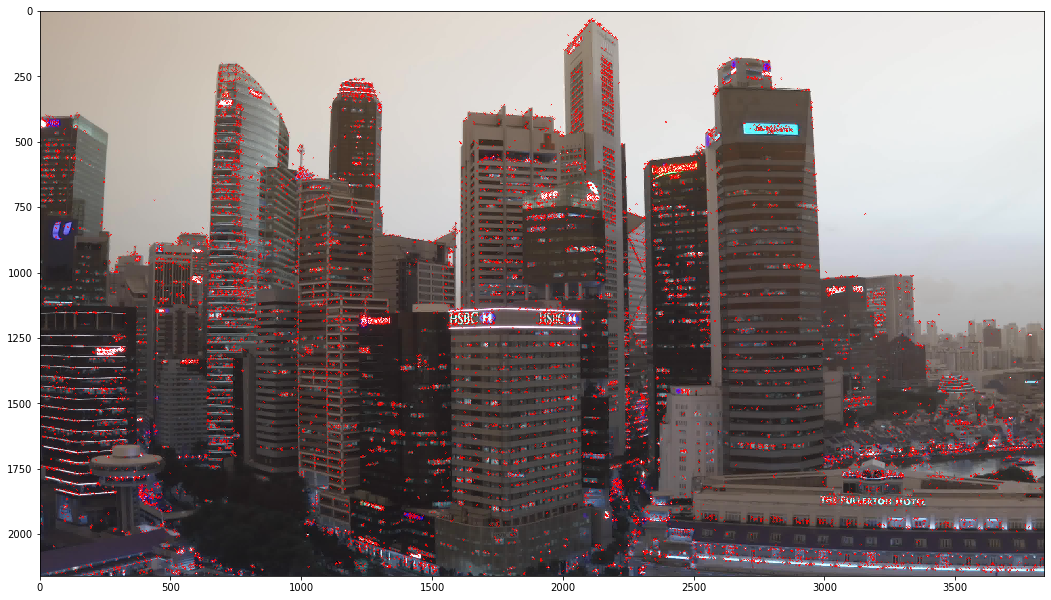

In [18]:
plt.figure(figsize=(18,13))
plt.imshow(img1_sift)


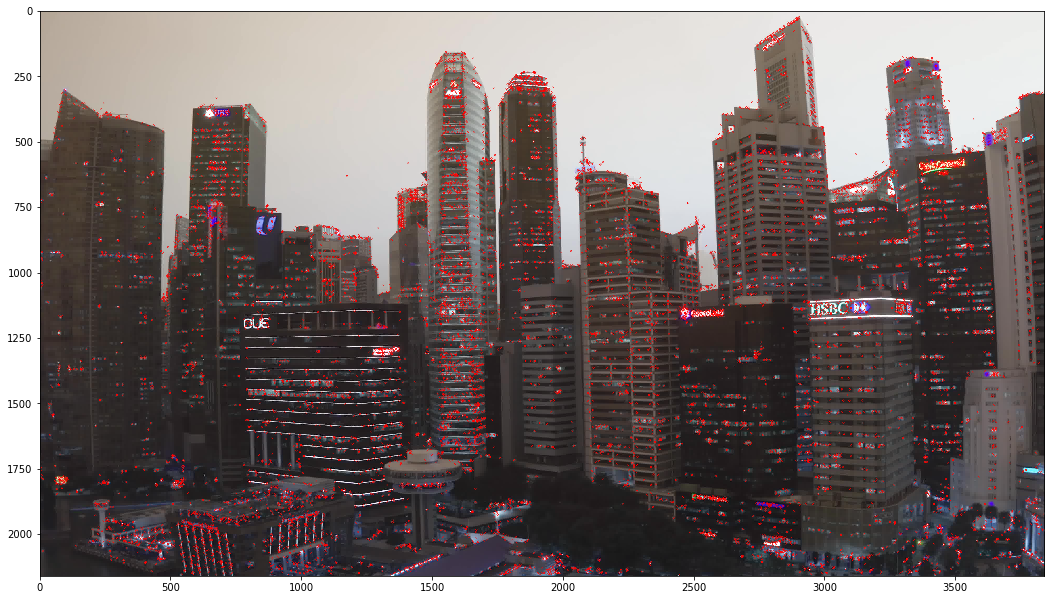

In [19]:
plt.figure(figsize=(18,13))
plt.imshow(img2_sift)

In [10]:
def get_harris_position(img,k = 0.04,threshold = 0.01):
    img = rgb2gray(img)
    height, width = np.shape(img)
    grandfx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    grandfy = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)  # compute the X direction and Y direction gradient 
    
    Ix2 = grandfx**2
    Iy2 = grandfy**2
    Ixy = grandfx*grandfy
    
    Ix2 = grandfx**2
    Iy2 = grandfy**2
    Ixy = grandfx*grandfy
    
    A = cv2.GaussianBlur(Ix2,(5,5),2)  # eliminate the noises
    B = cv2.GaussianBlur(Iy2,(5,5),2) 
    C = cv2.GaussianBlur(Ixy,(5,5),2)
    
    M = [np.array([[A[i, j], C[i, j]], #compute M
               [C[i, j], B[i, j]]]) for i in range(height) for j in range(width)]

    D, T = list(map(np.linalg.det, M)), list(map(np.trace, M))  #computer det(M) and trace(M)
    R = np.array([d-k*t**2 for d, t in zip(D, T)]) #computer R
    R_max = np.max(R)
    R = R.reshape(height, width)
    
    count = 0
    corners = []
    for i in range(1,height-1):  #computer whether Rij is the maximum value in a certain area and it is greater than the threshold*R_max
        for j in range(1,width-1):
            if R[i, j] > R_max*threshold:
                if R[i, j] == np.max(R[i-1:i+2, j-1:j+2]):
                    corners.append([i,j])
                    count += 1             
    corners = np.array(corners) #position of corners
    return corners

# to calculate single patch
def extract_patch(img, corner,n):
    x = corner[0]+30 # after pedding the location changes
    y = corner[1]+30 
    size_n = int(n/2)
    # #print(size_n)
    new_corner = [x,y]
    window = img[(x-size_n):(x+size_n+1), (y-size_n):(y+size_n+1)]
    window = cv2.cvtColor(window, cv2.COLOR_BGR2GRAY)
   # print(window)
    return new_corner, window 

def show_corner(img,corners):
    fig, ax = plt.subplots()  # show corners
    ax.imshow(img, cmap=plt.cm.gray)
    ax.plot(corners[:, 1], corners[:, 0], '.b', markersize=8)
    plt.title('k = 0.04, threshold = 0.1')
    plt.show()

# to take patches
def get_patch(corners,replicate_img,n):
    windows = []
    new_corners = []
    #print(np.shape(corners),np.shape(corners))
    # corners = corners2
    for each_corner in corners:
        new_corner,window = extract_patch(replicate_img,each_corner,n)
        # print(each_corner,window )
        # print("window1",np.shape(window1))
        # np.append(windows1,window1)
        window = sklearn.preprocessing.normalize(window)
        windows.append(window)
        new_corners.append(new_corner)
        # #print("windows1",np.shape(windows1))
    return new_corners, windows

# to calculate SSD and apply ratio to calculate the first_match
def ssd(p1,p2,new_corners1,new_corners2,r):
    similarity = []
    match = []
    locations_A = []
    locations_B = []
    for each_p1,each_location1 in zip(p1,new_corners1):
        for i, (each_p2,each_location2) in enumerate(zip(p2,new_corners2)):
            # print(i, each_p2,each_location2)
            p1_sub_p2 = np.subtract(each_p1,each_p2)
            p1p2square = np.power(p1_sub_p2,2)
            score = np.power(np.sum(p1p2square),0.5)
            # print("score",score)
            similarity.append([score,i])
            
            # print("np",np.amin(copied_sim,0)) 
            sorted_sim = sorted(similarity)
            # print("sorted",sorted_sim[0][0],sorted_sim[0][1])
        # print(sorted_sim)
        if sorted_sim[0][0] < r * sorted_sim[1][0]:
        	# print(sorted_sim,sorted_sim[0][0],sorted_sim[1][0])
        	match.append([each_p1,p2[sorted_sim[0][1]]])
        	# print("match",match)
        	# location.append([each_location1,new_corners2[sorted_sim[0][1]]])
        	locations_A.append(each_location1)
        	locations_B.append(new_corners2[sorted_sim[0][1]])
        	# print("locations",type(location),np.shape(location))
    # print("locations_A",locations_A,"locations_B",locations_B,"match",len(match))
    return match,locations_A,locations_B

def ssdstat(matches):
    totals = []
    for each_array1 in matches:
        total = np.subtract(each_array1[0:1], each_array1[1:2])
        total = np.power(total, 2)
        total = np.power(np.sum(total), 0.5)
        totals.append(total)
    return totals

def eliminateMultiCorrespondence(match_AtoB,match_BtoA):
    match3 = []
    for each_array1 in match_AtoB:
        for each_array2 in match_BtoA:
            # print("each",each_array1,np.shape(each_array1))
            if np.array_equal(each_array1[0:1:1], each_array2[1:2]) and np.array_equal(each_array2[0:1:1], each_array1[1:2]):
                match3.append([each_array1,each_array2])
                # match3[each_array1] = each_array2
                # print("match3",match3)
    return match3

def findLocations(matches,patches1,locations1,patches2,locations2):
    match_locations1 = []
    match_locations2 = []
    for each_patch1, each_location1,each_patch2,each_location2 in zip(patches1,locations1,patches2,locations2):
        # print("each_patch,each_location",each_patch,each_location)
        for each_match1 in matches[0]:
            # print("each_match",each_match,"matches",matches)
            if np.array_equal(each_match1[0:1:1][0],each_patch1):
                match_locations1.append(each_location1)
                match_locations2.append(each_location2)
    return match_locations1,match_locations2

def to_kpt(pt,size=1):
	return cv2.KeyPoint(pt[0],pt[1],size)

def stitch_imgs(img1, img2):
    """
    img1 and img2 can be the same
    """
    double_img = np.concatenate((img1, img2), axis = 1)
    return double_img 

def draw_lines(img, list_of_a_coords, list_of_b_coords, color = (255,255,255), thickness = 1):
    width = int(img.shape[1]/2)
    for A_coord, B_coord in zip(list_of_a_coords, list_of_b_coords):
        cv2.line(img, (A_coord[0],A_coord[1]),((B_coord[0]+width),B_coord[1]),color,thickness)
    return img

the patch size 5
r 0.8
corners1 861
corners2 543


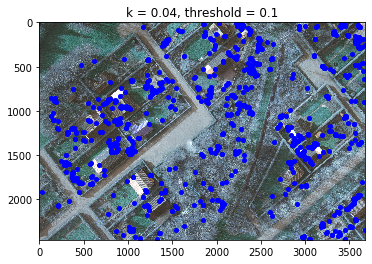

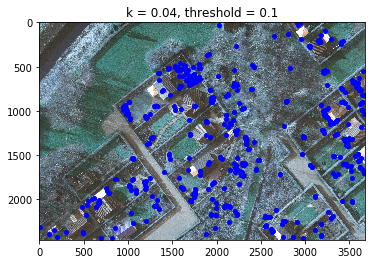

ValueError: Found array with dim 3. the normalize function expected <= 2.

In [9]:
# main programme
n = 5 #(the patch size, between 3-31, odd)
print("the patch size",n)
#(the ratio between best match and the second match)
r = 0.8
# for r in [0.95,0.9,0.85,0.8,0.75,0.7,0.65,0.6]:
print("r",r)

img1 = cv2.imread('./inputs/im1red.png')
img2 = cv2.imread('./inputs/im2red.png')

#print(type(img1),img1,np.shape(img1))
corners1 = get_harris_position(img1,threshold = 0.1)
corners2 = get_harris_position(img2,threshold = 0.1)
print("corners1",len(corners1))
print("corners2",len(corners2))
show_corner(img1,corners1)
show_corner(img2,corners2)


In [11]:

replicate_img1 = cv2.copyMakeBorder(img1,30,30,30,30,cv2.BORDER_REPLICATE)
replicate_img2 = cv2.copyMakeBorder(img2,30,30,30,30,cv2.BORDER_REPLICATE)
# print(np.shape(replicate_img2),replicate_img2)
#print("replicate_img1{}".format(np.shape(replicate_img1)))
#print("replicate_img1{}".format(np.shape(replicate_img2)))
new_corners1,patches1 = get_patch(corners1,replicate_img1,n)
# print(type(new_corners1),type(patches1))
new_corners2,patches2 = get_patch(corners2,replicate_img2,n)
# print("patches1",np.shape(patches1),"new_corners1",new_corners1,"patches2",np.shape(patches2),"new_corners2",new_corners2)
# show_patch(img1,patches1)
match_AtoB,locations_A,locations_B= ssd(patches1,patches2,new_corners1,new_corners2,r)
# print("match_AtoB",match_AtoB,"locations_AtoB",locations_AtoB,"matches",len(match_AtoB))
match_BtoA,locations_2A,locations_2B= ssd(patches2,patches1,new_corners2,new_corners1,r)
# print("match_BtoA",match_BtoA)
match_final = eliminateMultiCorrespondence(match_AtoB,match_BtoA)
print("match_final",match_final)
# keypoint1 = to_kpt(a for a in locations_A)
# keypoint2 = to_kpt(b for b in locations_B)
# print(keypoint1,keypoint2)
# img3 = cv2.drawMatches(replicate_img1,keypoint1,replicate_img2,keypoint2,None,match_AtoB[:10],flags = 2)
# plt.plot(img3)
print("matches",len(match_AtoB))
total = ssdstat(match_AtoB)
print(len(total))
print("std",np.std(total))
print("mean",np.mean(total))


match_locations1,match_locations2 = findLocations(match_final,patches1,locations_A,patches2,locations_B)
# match_locations2 = findLocations(match_final,patches2,new_corners2)
# print("match_locations",match_locations1,match_locations2)

combined_img = stitch_imgs(replicate_img1,replicate_img2)
img4 = draw_lines(combined_img, locations_A, locations_B, color = (255,255,255), thickness = 1)
# plt.plot(img4)
plt.imshow(img4,cmap = "gray")
plt.show()
